In [1]:
# Add path
import os
import sys
# project_root = os.path.dirname(os.path.abspath('..'))
project_root = os.path.dirname(os.path.dirname(os.path.abspath('..')))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

# Reload modules
from importlib import reload

In [2]:
import torch
from src.model.data_util import load_wandb_model, create_dataloader_from_wandb, data_from_loader

# Load model and dataset
run_id = 'e51hcsb9'
model, cfg = load_wandb_model(run=run_id, name='epoch=57.ckpt', project='simexp-03', replace=True, fallback_cfg_path='../../model/config.yaml',
                              wandb_cache_path='/cephfs/store/gr-mc2473/lc865/wandb_cache')
# train_loader, valid_loader, info = create_dataloader_from_wandb(cfg)

/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


Imported model from run "e51hcsb9".
  | Name    | Type    | Params | Mode
-------------------------------------------
0 | encoder | Encoder | 8.9 M  | eval
1 | decoder | Decoder | 8.6 M  | eval
-------------------------------------------
17.5 M    Trainable params
0         Non-trainable params
17.5 M    Total params
70.150    Total estimated model params size (MB)
0         Modules in train mode
78        Modules in eval mode


In [3]:
batch_size = 1
syntax_shape = (batch_size, cfg.model.io_format.seq_len, cfg.model.io_format.token_cnt)
x = torch.zeros(syntax_shape, dtype=torch.float32)
sample_eps = 1e-3
sample_count = 8
input = {
    'input_sample': x,
    'sample_eps': sample_eps,
    'sample_count': sample_count
}

In [5]:
fpath = f'./onnx-models/model-{run_id}.onnx'
print(os.path.abspath(fpath))


/mhome/damtp/q/lc865/workspace/similar-expressions/src/dev/ONNX/onnx-models/model-e51hcsb9.onnx


In [6]:
fpath = f'./onnx-models/model-{run_id}.onnx'
model.to_onnx(fpath, tuple(input.values()), export_params=True)

## 2. Load model via ONNX

In [23]:
input_arr = data_from_loader(train_loader, 'x', idx=0).detach().numpy()

In [31]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession(fpath)
input_name = ort_session.get_inputs()[0].name
sample_eps_name = ort_session.get_inputs()[1].name
ort_inputs = {input_name: input_arr, sample_eps_name: np.array([sample_eps], dtype=np.float64)}
ort_outs = ort_session.run(None, ort_inputs)

In [19]:
for a in ort_outs:
    print(a.shape)

(1, 32)
(1, 32)
(1, 32)
(1, 15, 14)
(1, 100)


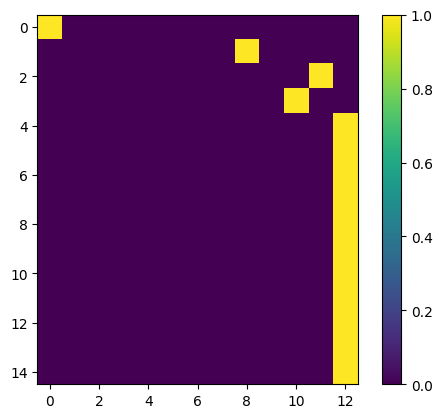

In [39]:
from matplotlib import pyplot as plt

plt.imshow(torch.tensor(ort_outs[3].squeeze()[:, :-1]).softmax(dim=-1).detach().numpy())
plt.colorbar()
plt.show()